# Functional Encryption - Classification and information leakage


## Purpose

We proceed like part 3 except we put a public network over the private output not only for the collateral task but also for main one.

Actually, we also provide more epochs for the main task to train as this training is fast and more epochs are required when the model gets deeper. The model isn't deeper for the collateral task so we don't have to increase the number of epochs there.

Moreover, we provide a new parameter `PRIVATE_OUTPUT_SIZE = 10` which controls the size of the private output, as this doesn't need anymore to be 10 for we have another public network on top of it.


# 4 Tempering Collateral Learning


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import learn
from learn import show_results
# We now import from the collateral module
from learn import collateral

## 4.1 Simultaneous training

We will do the training in a single phase, as the collateral phase does not interfere with the main one.

We have reduced the collateral network size, it now just a simple FFN, to keep computation fast. We'll get back to CNN later don't worry!

The way the procedure is handled is the following: we alternate epochs, one on the main task which updates the quadratic and the character part of the network, and one on the collateral task which only updates the font family part of the network.

Therefore, if we call `Q` the quadratic part, `C` the net on top of `Q` used to predict characters and `F` the net for predicting families, the global network will be structured as follows:
```
  |
  Q
 / \
C   F
|   |
```

We will do a 2-phase process:
 - `Optimize: Q + C`
 - `Optimize: Freezed(Q) + F`

In [3]:
PRIVATE_OUTPUT_SIZE = 10
N_CHARS = 10
N_FONTS = 2

class Parser:
    def __init__(self):
        self.epochs = 10
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300

class CollateralNet(nn.Module):
    def __init__(self):
        super(CollateralNet, self).__init__()
        self.proj1 = nn.Linear(784, 40)
        self.diag1 = nn.Linear(40, PRIVATE_OUTPUT_SIZE, bias=False)

        # --- FFN for characters
        self.lin1 = nn.Linear(PRIVATE_OUTPUT_SIZE, 32)
        self.lin2 = nn.Linear(32, N_CHARS)

        # --- FFN for families
        self.lin3 = nn.Linear(PRIVATE_OUTPUT_SIZE, 32)
        self.lin4 = nn.Linear(32, N_FONTS)

    def quad(self, x):
        # --- Quadratic
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

    def char_net(self, x):
        # --- FFN
        x = F.relu(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

    def font_net(self, x):
        # --- FFN
        x = F.relu(x)
        x = F.relu(self.lin3(x))
        x = self.lin4(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.char_net(x)
        return F.log_softmax(x, dim=1)

    def forward_font(self, x):
        x = self.quad(x)
        x = self.font_net(x)
        return F.log_softmax(x, dim=1)
    
    # We add the ability to freeze some layers to ensure that the collateral task does
    # not modify the quadratic net
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.lin3, self.lin4]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params

    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False

    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
    
    

In [7]:
def dual_learning_phase(model):
    """
    Perform a dual learning phase
    """
    args = Parser()
    
    train_loader, test_loader = collateral.get_data_loaders(args)

    #optimizer = optim.Adam(model.parameters(), lr=args.lr)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + 1):
        collateral.train(args, model, train_loader, optimizer, epoch, 0, True, False, False, False)
        test_perf_char, test_perf_font = collateral.test(args, model, test_loader, False)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

In [8]:
results = {}

In [9]:
model = CollateralNet()
test_perfs_char_perturbate, test_perfs_font_perturbate = dual_learning_phase(model)
results[f"Main task with output size {PRIVATE_OUTPUT_SIZE}"] = test_perfs_char_perturbate
results[f"Collateral task with output size {PRIVATE_OUTPUT_SIZE}"] = test_perfs_font_perturbate

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.288454 Loss Font: 0.718573
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 1.878332 Loss Font: 0.690706
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.804431 Loss Font: 0.575631
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.386138 Loss Font: 0.720004

Test set: Accuracy Char : 8642/10000 (86.42%)
          Accuracy Font : 5981/10000 (59.81%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.373366 Loss Font: 0.633376
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.397147 Loss Font: 0.640782
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.240672 Loss Font: 0.590604
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.096954 Loss Font: 0.601987

Test set: Accuracy Char : 9532/10000 (95.32%)
          Accuracy Font : 6719/10000 (67.19%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.172076 Loss Font: 0.620654
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.143340 Loss Font: 0.624026
Train Epoch: 3 [38400/60000 (

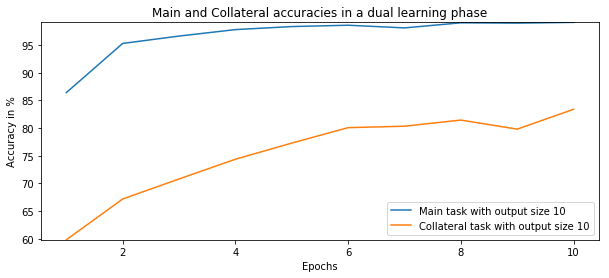

In [10]:
show_results(results, title="Main and Collateral accuracies in a dual learning phase")

As expected, the main task is not affected by our new process. As expected, the collateral network performs less well compared to Part 3 which is also expected as it is way smaller, but still achieves >82% accuracy. We'll do the test with the CNN at the end of this tutorial to make sure we can infer results on CNN looking at smaller networks which are faster to train.

## 4.2 Reducing the private output size


We now change the output of the private network to see how the main and collateral accuracy degrade.

In [11]:
for PRIVATE_OUTPUT_SIZE in [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]:
    print('\n -----', PRIVATE_OUTPUT_SIZE)
    model = CollateralNet()
    test_perfs_char_perturbate, test_perfs_font_perturbate = dual_learning_phase(model)
    results[f"Main task with output size {PRIVATE_OUTPUT_SIZE}"] = test_perfs_char_perturbate
    results[f"Collateral task with output size {PRIVATE_OUTPUT_SIZE}"] = test_perfs_font_perturbate


 ----- 10
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.269649 Loss Font: 0.708297
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 1.616001 Loss Font: 0.674110
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.591641 Loss Font: 0.627130
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.459737 Loss Font: 0.605778

Test set: Accuracy Char : 8791/10000 (87.91%)
          Accuracy Font : 6617/10000 (66.17%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.451807 Loss Font: 0.588058
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.382171 Loss Font: 0.644877
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.204297 Loss Font: 0.607601
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.037514 Loss Font: 0.515182

Test set: Accuracy Char : 9569/10000 (95.69%)
          Accuracy Font : 7207/10000 (72.07%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.234842 Loss Font: 0.543624
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.144722 Loss Font: 0.471594
Train Epoch: 3 [38

Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.501741 Loss Font: 0.659975
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.299572 Loss Font: 0.683927
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.065714 Loss Font: 0.637012

Test set: Accuracy Char : 9505/10000 (95.05%)
          Accuracy Font : 6426/10000 (64.26%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.209793 Loss Font: 0.648991
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.158073 Loss Font: 0.621779
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.021595 Loss Font: 0.567591
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.036201 Loss Font: 0.609439

Test set: Accuracy Char : 9692/10000 (96.92%)
          Accuracy Font : 6726/10000 (67.26%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.130387 Loss Font: 0.551832
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.108617 Loss Font: 0.548671
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.040601 Loss Font: 0.653528
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.165607 Loss Font: 0.583914

Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.205491 Loss Font: 0.593643
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.058040 Loss Font: 0.596879
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.137083 Loss Font: 0.551917

Test set: Accuracy Char : 9462/10000 (94.62%)
          Accuracy Font : 6705/10000 (67.05%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.031928 Loss Font: 0.638296
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.040590 Loss Font: 0.671783
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.100789 Loss Font: 0.584382
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.189373 Loss Font: 0.569883

Test set: Accuracy Char : 9508/10000 (95.08%)
          Accuracy Font : 6934/10000 (69.34%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.245857 Loss Font: 0.662132
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.057571 Loss Font: 0.588520
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.133787 Loss Font: 0.517221
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.080670 Loss Font: 0.584703

Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.056116 Loss Font: 0.611965
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.059324 Loss Font: 0.588510
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.140013 Loss Font: 0.722780

Test set: Accuracy Char : 9661/10000 (96.61%)
          Accuracy Font : 7159/10000 (71.59%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.103128 Loss Font: 0.532660
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.018894 Loss Font: 0.517555
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.040878 Loss Font: 0.526978
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.046790 Loss Font: 0.504615

Test set: Accuracy Char : 9765/10000 (97.65%)
          Accuracy Font : 7280/10000 (72.80%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.221688 Loss Font: 0.690722
Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.349356 Loss Font: 0.495458
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.121067 Loss Font: 0.564838
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.070899 Loss Font: 0.524759

Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.551763 Loss Font: 0.707495
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.502762 Loss Font: 0.693962
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.638529 Loss Font: 0.662704

Test set: Accuracy Char : 8108/10000 (81.08%)
          Accuracy Font : 5709/10000 (57.09%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.480537 Loss Font: 0.672220
Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 1.115065 Loss Font: 0.684632
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.713154 Loss Font: 0.672375
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.378615 Loss Font: 0.642764

Test set: Accuracy Char : 8234/10000 (82.34%)
          Accuracy Font : 5776/10000 (57.76%)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.360710 Loss Font: 0.662114
Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.422290 Loss Font: 0.687145
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.458750 Loss Font: 0.654657
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.300948 Loss Font: 0.661674

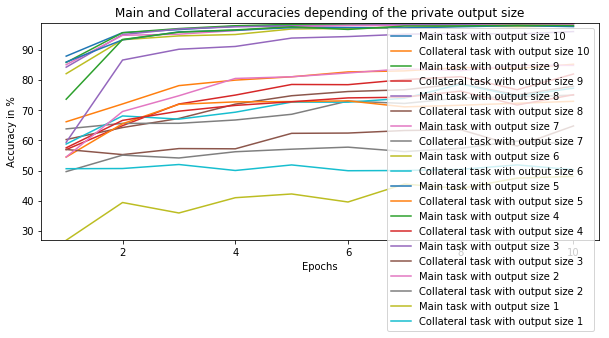

In [12]:
show_results(results, title="Main and Collateral accuracies depending of the private output size")


Let's zoom on the main accuracy

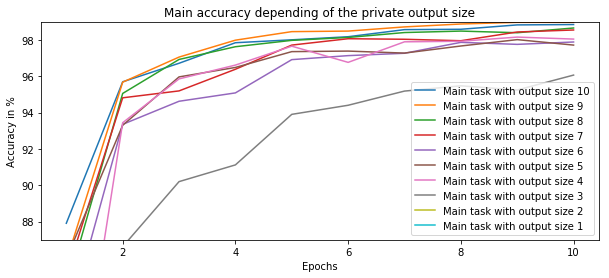

In [49]:
main_results = {k:v for k, v in results.items() if 'Main' in k}
show_results(main_results, title="Main accuracy depending of the private output size", ymin=87)

And the collateral one, even if it is not very readable

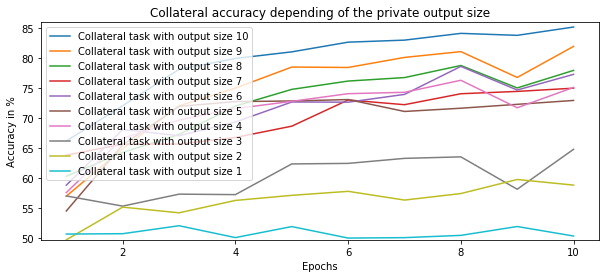

In [50]:
collateral_results = {k:v for k, v in results.items() if 'Collateral' in k}
show_results(collateral_results, title="Collateral accuracy depending of the private output size", ymax=86)

In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [51]:
def draw_pareto(main_results, collateral_results):
    output_sizes = sorted([int(title.split(' ')[-1]) for title in main_results.keys()])
    main_results = {int(title.split(' ')[-1]): res for title, res in main_results.items()}
    collateral_results = {int(title.split(' ')[-1]): res for title, res in collateral_results.items()}
    
    y_m = []
    y_c = []
    for output_size in output_sizes:
        y_m.append(
            100 - np.mean(main_results[output_size][-4:])
        )
        y_c.append(
            100 - np.mean(collateral_results[output_size][-4:])
        )

    plt.figure(figsize=(7, 7))
    plt.plot(y_m, y_c, 'o-', label="Output size")
    for i, output_size in enumerate(output_sizes):
        plt.annotate(str(output_size), (y_m[i] + 1, y_c[i] - 1))
    plt.ylabel('Collateral Error')
    plt.xlabel('Main Task Error')
    #plt.ylim(,)
    #plt.title("Trade-off between the main and collateral accuracies")
    plt.legend()
    plt.savefig('Pareto_OutputSize_noSabotage.png')
    plt.show()

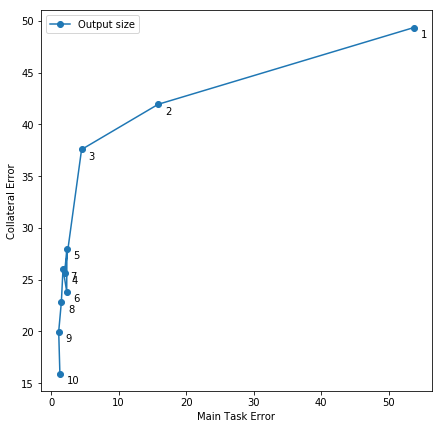

In [52]:
draw_pareto(main_results, collateral_results)

What we observe here is interesting, the main task does not present significant weakness until we get at size 3 where we drop to 97.5% which is still very good although 1% under the other accuracies. In return, the collateral accuracy starts significantly to decrease for output size 5, and keeps decreasing. At size 4, it is only 67% on average so 15% less than the baseline.

As a conclusion, depending on how crucial the main task is, we might keep an output size of 3 or 4.

## 4.3 When the collateral model is a CNN

We perform the same experiment but with the collateral model being a CNN, to see is we observ similar behaviours.

In [43]:
class CollateralNet(nn.Module):
    def __init__(self):
        super(CollateralNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, PRIVATE_OUTPUT_SIZE, bias=False)

        # --- FFN for characters
        self.lin1 = nn.Linear(PRIVATE_OUTPUT_SIZE, 32)
        self.lin2 = nn.Linear(32, N_CHARS)

        # --- Junction
        self.jct = nn.Linear(PRIVATE_OUTPUT_SIZE, 784)

        # --- CNN for families
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, N_FONTS)

    def quad(self, x):
        # --- Quadratic
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

    def char_net(self, x):
        # --- FFN
        x = F.relu(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

    def font_net(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)

        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.char_net(x)
        return F.log_softmax(x, dim=1)

    def forward_font(self, x):
        x = self.quad(x)
        x = self.font_net(x)
        return F.log_softmax(x, dim=1)
    
    # We add the ability to freeze some layers to ensure that the collateral task does
    # not modify the quadratic net
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params

    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False

    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
    
    

In [44]:
cnn_results = {}
for PRIVATE_OUTPUT_SIZE in [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]:
    print('\n -----', PRIVATE_OUTPUT_SIZE)
    model = CollateralNet()
    test_perfs_char_perturbate, test_perfs_font_perturbate = dual_learning_phase(model)
    cnn_results[f"Main task with output size {PRIVATE_OUTPUT_SIZE}"] = test_perfs_char_perturbate
    cnn_results[f"Collateral task withoutput size {PRIVATE_OUTPUT_SIZE}"] = test_perfs_font_perturbate


 ----- 10
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.344008 Loss Font: 0.686329
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 1.546081 Loss Font: 0.689847
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.467052 Loss Font: 0.563169
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.429006 Loss Font: 0.467837

Test set: Accuracy Char : 8995/10000 (89.95%)
          Accuracy Font : 7667/10000 (76.67%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.267551 Loss Font: 0.528971
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.172447 Loss Font: 0.408802
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.158899 Loss Font: 0.373531
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.042128 Loss Font: 0.346760

Test set: Accuracy Char : 9606/10000 (96.06%)
          Accuracy Font : 8309/10000 (83.09%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.160753 Loss Font: 0.377356
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.177379 Loss Font: 0.313664
Train Epoch: 3 [38


Test set: Accuracy Char : 8880/10000 (88.80%)
          Accuracy Font : 7389/10000 (73.89%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.324607 Loss Font: 0.518692
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.288807 Loss Font: 0.544927
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.208885 Loss Font: 0.382508
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.063677 Loss Font: 0.293738

Test set: Accuracy Char : 9620/10000 (96.20%)
          Accuracy Font : 8389/10000 (83.89%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.184312 Loss Font: 0.274271
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.162024 Loss Font: 0.327895
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.017418 Loss Font: 0.283681
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.026876 Loss Font: 0.241334

Test set: Accuracy Char : 9754/10000 (97.54%)
          Accuracy Font : 8758/10000 (87.58%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.124584 Loss Font: 0.315254
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.050604 Loss F

Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.064808 Loss Font: 0.471571

Test set: Accuracy Char : 9487/10000 (94.87%)
          Accuracy Font : 8029/10000 (80.29%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.199115 Loss Font: 0.350405
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.087475 Loss Font: 0.376717
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.030793 Loss Font: 0.376762
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.039212 Loss Font: 0.371999

Test set: Accuracy Char : 9701/10000 (97.01%)
          Accuracy Font : 8281/10000 (82.81%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.047427 Loss Font: 0.370547
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.025770 Loss Font: 0.341691
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.084549 Loss Font: 0.419483
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.079968 Loss Font: 0.395533

Test set: Accuracy Char : 9766/10000 (97.66%)
          Accuracy Font : 8170/10000 (81.70%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.086189 Loss F

Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.063970 Loss Font: 0.568079
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.037935 Loss Font: 0.592763

Test set: Accuracy Char : 9608/10000 (96.08%)
          Accuracy Font : 6832/10000 (68.32%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.037823 Loss Font: 0.533153
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.091320 Loss Font: 0.452832
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.033057 Loss Font: 0.551227
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.152801 Loss Font: 0.498049

Test set: Accuracy Char : 9666/10000 (96.66%)
          Accuracy Font : 7076/10000 (70.76%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.053476 Loss Font: 0.567648
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.071301 Loss Font: 0.652069
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.039134 Loss Font: 0.511306
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.032307 Loss Font: 0.548362

Test set: Accuracy Char : 9719/10000 (97.19%)
          Accuracy Font : 7

Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.303404 Loss Font: 0.676760
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.302094 Loss Font: 0.707646
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.245415 Loss Font: 0.690120

Test set: Accuracy Char : 8908/10000 (89.08%)
          Accuracy Font : 5900/10000 (59.00%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.432391 Loss Font: 0.658988
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.193429 Loss Font: 0.716881
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.316733 Loss Font: 0.657470
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.178666 Loss Font: 0.698835

Test set: Accuracy Char : 9178/10000 (91.78%)
          Accuracy Font : 5769/10000 (57.69%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.242666 Loss Font: 0.629765
Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.378894 Loss Font: 0.634451
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.205240 Loss Font: 0.638452
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.307186 Loss Font: 0.649678

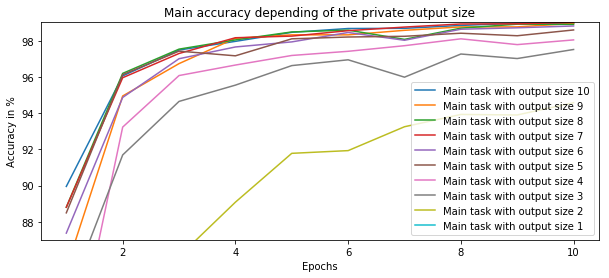

In [45]:
main_results = {k:v for k, v in cnn_results.items() if 'Main' in k}
show_results(main_results, title="Main accuracy depending of the private output size", ymin=87)

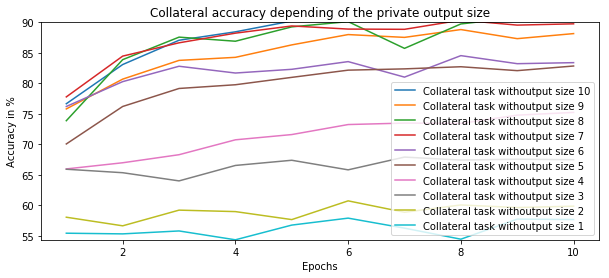

In [46]:
collateral_results = {k:v for k, v in cnn_results.items() if 'Collateral' in k}
show_results(collateral_results, title="Collateral accuracy depending of the private output size", ymax=90)

Down to output_size 4, we observe a similar decrease in accuracy down to 74%. However, for output size 2 & 3, the collateral CNN fails at learning anything, because the output is definitely too small compared to the learning rate. We could reduce the learning rate to have those results, but what we have already is convincing: we will keep an output size between 3 and 4 depending on our needs.

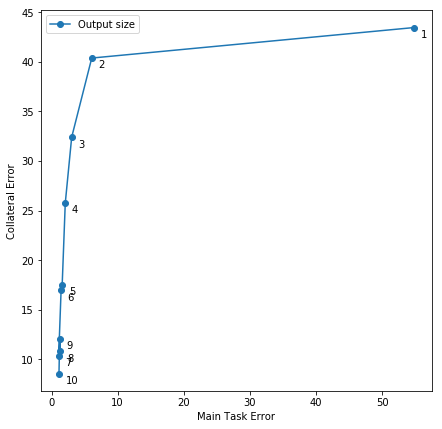

In [47]:
draw_pareto(main_results, collateral_results)

## Conclusion

What we observe here is that the private output size is a key factor to resist against collateral models. 

One interesting to notice also is that in Functional Encrytion, the execution time scales almost linearly with the the output size, so having a output size of 4 compared to 10 is great benefit!

In Part 4 bis you can find a more complete execution to produce reliable figures. There's nothing new except more computations and figures.